# [**Classification de documents textuels à l'aide de caractéristiques rares**](https://nbviewer.org/github/Franck-PepperLabs/pepper_data-science_practising/blob/main/Sklearn/examples/text/plot_document_classification_20newsgroups.ipynb)<br/>([*Classification of text documents using sparse features*](https://scikit-learn.org/stable/auto_examples/text/plot_document_classification_20newsgroups.html))

Ceci est un exemple montrant comment scikit-learn peut être utilisé pour classifier des documents par sujets en utilisant une approche [wkpd:**sac de mots**](https://en.wikipedia.org/wiki/Bag-of-words_model). Cet exemple utilise une matrice creuse de termes de document pondérée Tf-idf pour coder les caractéristiques et illustre divers classifieurs qui peuvent gérer efficacement les matrices creuses.

Pour l'analyse de documents via une approche d'apprentissage non supervisée, voir l'exemple de script [**Regroupement de documents textes à l'aide de k-means**](https://scikit-learn.org/stable/auto_examples/text/plot_document_clustering.html).

In [ ]:
# Author: Peter Prettenhofer <peter.prettenhofer@gmail.com>
#         Olivier Grisel <olivier.grisel@ensta.org>
#         Mathieu Blondel <mathieu@mblondel.org>
#         Arturo Amor <david-arturo.amor-quiroz@inria.fr>
#         Lars Buitinck
# License: BSD 3 clause

## Chargement et vectorisation du jeu de données texte des 20 newsgroups

Nous définissons une fonction pour charger des données à partir de l'ensemble de [**Le jeu de donnée des 20 newsgroups** (7.22)](https://scikit-learn.org/stable/datasets/real_world.html#newsgroups-dataset), qui comprend environ 18 000 articles de newsgroups sur 20 sujets répartis en deux sous-ensembles : l'un pour l'entraînement (ou le développement) et l'autre pour les tests (ou pour l'évaluation des performances). Notez que, par défaut, les exemples de texte contiennent certaines métadonnées de message telles que les `'headers'`, `'footers'` (signatures) et les `'quotes'` vers d'autres publications. La fonction `'fetch_20newsgroups'` accepte donc un paramètre nommé `'remove'` pour tenter de supprimer ces informations qui peuvent rendre le problème de classification "trop facile". Ceci est réalisé en utilisant des heuristiques simples qui ne sont ni parfaites ni standard, donc désactivées par défaut.

In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from time import time

categories = [
    "alt.atheism",
    "talk.religion.misc",
    "comp.graphics",
    "sci.space",
]


def size_mb(docs):
    return sum(len(s.encode("utf-8")) for s in docs) / 1e6


def load_dataset(verbose=False, remove=()):
    """Load and vectorize the 20 newsgroups dataset."""

    data_train = fetch_20newsgroups(
        subset="train",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    data_test = fetch_20newsgroups(
        subset="test",
        categories=categories,
        shuffle=True,
        random_state=42,
        remove=remove,
    )

    # order of labels in `target_names` can be different from `categories`
    target_names = data_train.target_names

    # split target in a training set and a test set
    y_train, y_test = data_train.target, data_test.target

    # Extracting features from the training data using a sparse vectorizer
    t0 = time()
    vectorizer = TfidfVectorizer(
        sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english"
    )
    X_train = vectorizer.fit_transform(data_train.data)
    duration_train = time() - t0

    # Extracting features from the test data using the same vectorizer
    t0 = time()
    X_test = vectorizer.transform(data_test.data)
    duration_test = time() - t0

    feature_names = vectorizer.get_feature_names_out()

    if verbose:

        # compute size of loaded data
        data_train_size_mb = size_mb(data_train.data)
        data_test_size_mb = size_mb(data_test.data)

        print(
            f"{len(data_train.data)} documents - "
            f"{data_train_size_mb:.2f}MB (training set)"
        )
        print(f"{len(data_test.data)} documents - {data_test_size_mb:.2f}MB (test set)")
        print(f"{len(target_names)} categories")
        print(
            f"vectorize training done in {duration_train:.3f}s "
            f"at {data_train_size_mb / duration_train:.3f}MB/s"
        )
        print(f"n_samples: {X_train.shape[0]}, n_features: {X_train.shape[1]}")
        print(
            f"vectorize testing done in {duration_test:.3f}s "
            f"at {data_test_size_mb / duration_test:.3f}MB/s"
        )
        print(f"n_samples: {X_test.shape[0]}, n_features: {X_test.shape[1]}")

    return X_train, X_test, y_train, y_test, feature_names, target_names

## Analyse d'un classifieur de documents par sac de mots

Nous allons maintenant entraîner un classifieur deux fois, une fois sur les échantillons de texte incluant les métadonnées et une fois après avoir supprimé ces métadonnées. Dans les deux cas, nous analyserons les erreurs de classification sur un ensemble de test à l'aide d'une **matrice de confusion** et inspecterons les coefficients qui définissent la fonction de classification des modèles entraînés.

### Modèle sans suppression des métadonnées

Nous commençons par utiliser la fonction personnalisée `load_dataset` pour charger les données sans suppression des métadonnées.

In [2]:
X_train, X_test, y_train, y_test, feature_names, target_names = load_dataset(
    verbose=True
)

2034 documents - 3.98MB (training set)
1353 documents - 2.87MB (test set)
4 categories
vectorize training done in 0.454s at 8.756MB/s
n_samples: 2034, n_features: 7831
vectorize testing done in 0.261s at 10.984MB/s
n_samples: 1353, n_features: 7831


Notre premier modèle est une instance de la classe [**`RidgeClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier). Il s'agit d'un modèle de classification linéaire qui utilise l'erreur quadratique moyenne sur les cibles codées {-1, 1}, une pour chaque classe possible. Contrairement à [**`LogisticRegression`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression), [**`RidgeClassifier`**](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html#sklearn.linear_model.RidgeClassifier) ne fournit pas de prédictions probabilistes (pas de méthode `predict_proba`), mais il est souvent plus rapide à entraîner.

In [3]:
from sklearn.linear_model import RidgeClassifier

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

Nous traçons la matrice de confusion de ce classifieur pour trouver s'il existe un schéma dans les erreurs de classification.

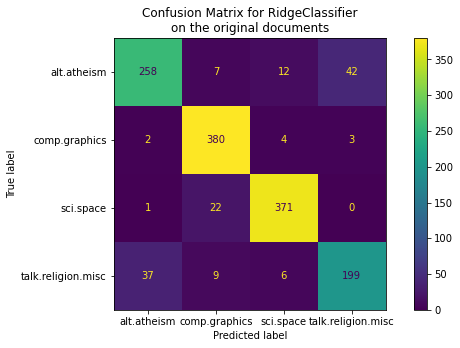

In [4]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

La matrice de confusion met en évidence que les documents de la classe `alt.atheism` sont souvent confondus avec les documents de la classe `talk.religion.misc` et vice-versa, ce qui est attendu puisque les sujets sont sémantiquement liés.

Nous observons également que certains documents de la classe `sci.space` peuvent être mal classés comme `comp.graphics` alors que l'inverse est beaucoup plus rare. Une inspection manuelle de ces documents mal classifiés serait nécessaire pour avoir un aperçu de cette asymétrie. Il se peut que le vocabulaire du sujet spatial soit plus spécifique que le vocabulaire de l'infographie.

Nous pouvons acquérir une meilleure compréhension de la façon dont ce classifieur prend ses décisions en examinant les mots avec les **effets de caractéristiques moyens** les plus élevés :

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0       keith      graphics     space          christian
1         god    university      nasa                com
2    atheists        thanks     orbit                god
3      people          does      moon           morality
4     caltech         image    access             people


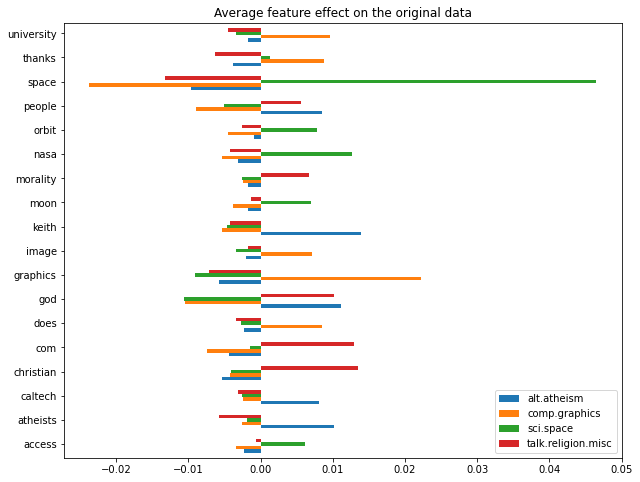

In [5]:
import pandas as pd
import numpy as np


def plot_feature_effects():
    # learned coefficients weighted by frequency of appearance
    average_feature_effects = clf.coef_ * np.asarray(X_train.mean(axis=0)).ravel()

    for i, label in enumerate(target_names):
        top5 = np.argsort(average_feature_effects[i])[-5:][::-1]
        if i == 0:
            top = pd.DataFrame(feature_names[top5], columns=[label])
            top_indices = top5
        else:
            top[label] = feature_names[top5]
            top_indices = np.concatenate((top_indices, top5), axis=None)
    top_indices = np.unique(top_indices)
    predictive_words = feature_names[top_indices]

    # plot feature effects
    bar_size = 0.25
    padding = 0.75
    y_locs = np.arange(len(top_indices)) * (4 * bar_size + padding)

    fig, ax = plt.subplots(figsize=(10, 8))
    for i, label in enumerate(target_names):
        ax.barh(
            y_locs + (i - 2) * bar_size,
            average_feature_effects[i, top_indices],
            height=bar_size,
            label=label,
        )
    ax.set(
        yticks=y_locs,
        yticklabels=predictive_words,
        ylim=[
            0 - 4 * bar_size,
            len(top_indices) * (4 * bar_size + padding) - 4 * bar_size,
        ],
    )
    ax.legend(loc="lower right")

    print("top 5 keywords per class:")
    print(top)

    return ax


_ = plot_feature_effects().set_title("Average feature effect on the original data")

On peut observer que les mots les plus prédictifs sont souvent fortement associés positivement à une seule classe et négativement associés à toutes les autres classes. La plupart de ces associations positives sont assez faciles à interpréter. Cependant, certains mots tels que `"god"` et `"people"` sont positivement associés à la fois à `talk.misc.religion` et à `alt.atheism`, car ces deux classes partagent un vocabulaire commun. Notez cependant qu'il existe également des mots tels que `"christian"` et `"morality"` qui ne sont associés que positivement à `talk.misc.religion`. De plus, dans cette version de l'ensemble de données, le mot `"caltech"` est l'une des principales caractéristiques prédictives de l'athéisme en raison de la pollution de l'ensemble de données provenant d'une sorte de métadonnées telles que les adresses e-mail de l'expéditeur des e-mails précédents dans la discussion comme peut être vu ci-dessous:

In [6]:
data_train = fetch_20newsgroups(
    subset="train", categories=categories, shuffle=True, random_state=42
)

for doc in data_train.data:
    if "caltech" in doc:
        print(doc)
        break

From: livesey@solntze.wpd.sgi.com (Jon Livesey)
Subject: Re: Morality? (was Re: <Political Atheists?)
Organization: sgi
Lines: 93
Distribution: world
NNTP-Posting-Host: solntze.wpd.sgi.com

In article <1qlettINN8oi@gap.caltech.edu>, keith@cco.caltech.edu (Keith Allan Schneider) writes:
|> livesey@solntze.wpd.sgi.com (Jon Livesey) writes:
|> 
|> >>>Explain to me
|> >>>how instinctive acts can be moral acts, and I am happy to listen.
|> >>For example, if it were instinctive not to murder...
|> >
|> >Then not murdering would have no moral significance, since there
|> >would be nothing voluntary about it.
|> 
|> See, there you go again, saying that a moral act is only significant
|> if it is "voluntary."  Why do you think this?

If you force me to do something, am I morally responsible for it?

|> 
|> And anyway, humans have the ability to disregard some of their instincts.

Well, make up your mind.    Is it to be "instinctive not to murder"
or not?

|> 
|> >>So, only intelligent beings ca

De tels en-têtes, pieds de page de signature (et métadonnées citées de messages précédents) peuvent être considérés comme des informations secondaires qui révèlent artificiellement le groupe de discussion en identifiant les membres enregistrés et on préférerait que notre classifieur de texte n'apprenne qu'à partir du "contenu principal" de chaque document texte au lieu de s'appuyer sur l'identité divulguée des auteurs.

### Modèle avec suppression des métadonnées

L'option `remove` du chargeur d'ensembles de données de 20 groupes de discussion dans scikit-learn permet de tenter de manière heuristique de filtrer certaines de ces métadonnées indésirables qui facilitent artificiellement le problème de classification. Sachez qu'un tel filtrage du contenu du texte est loin d'être parfait.

Essayons de tirer parti de cette option pour former un classifieur de texte qui ne s'appuie pas trop sur ce type de métadonnées pour prendre ses décisions :

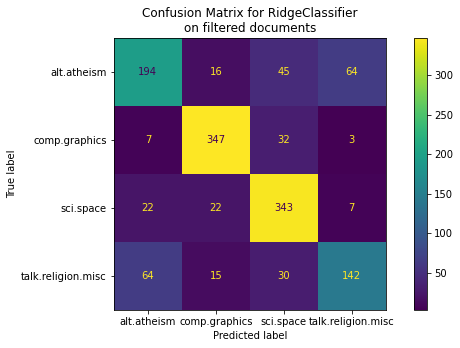

In [7]:
(
    X_train,
    X_test,
    y_train,
    y_test,
    feature_names,
    target_names,
) = load_dataset(remove=("headers", "footers", "quotes"))

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
clf.fit(X_train, y_train)
pred = clf.predict(X_test)

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non filtered documents"
)

En regardant la matrice de confusion, il est plus évident que les scores du modèle entraîné avec les métadonnées étaient trop optimistes. Le problème de classification sans accès aux métadonnées est moins précis mais plus représentatif du problème de classification de texte visé.

top 5 keywords per class:
  alt.atheism comp.graphics sci.space talk.religion.misc
0         don      graphics     space                god
1      people          file      like          christian
2         say        thanks      nasa              jesus
3    religion         image     orbit         christians
4        post          does    launch              wrong


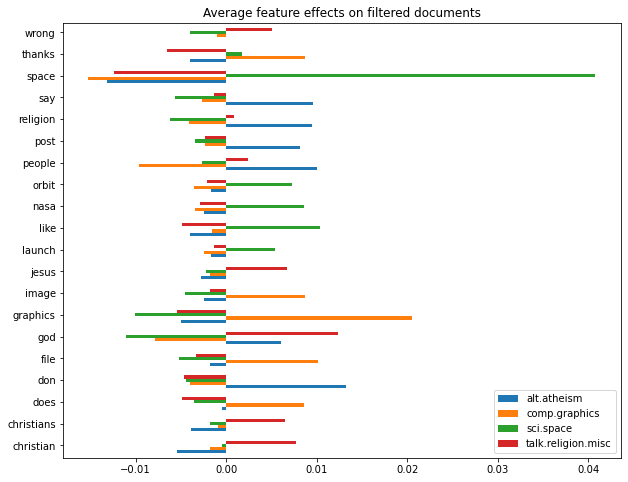

In [8]:
_ = plot_feature_effects().set_title("Average feature effects on filtered documents")

Dans la section suivante, nous gardons le jeu de données sans métadonnées pour comparer plusieurs classifieurs.

## Comparaison des performances des classificateurs

Scikit-learn fournit de nombreux types d'algorithmes de classification. Dans cette section, nous allons entraîner une sélection de ces classifieurs sur le même problème de classification de texte et mesurer à la fois leurs performances de généralisation (précision sur l'ensemble de test) et leurs performances de calcul (vitesse), à la fois au moment de l'apprentissage et au moment du test. À cette fin, nous définissons les utilitaires de benchmarking suivants :

In [9]:
from sklearn.utils.extmath import density
from sklearn import metrics


def benchmark(clf, custom_name=False):
    print("_" * 80)
    print("Training: ")
    print(clf)
    t0 = time()
    clf.fit(X_train, y_train)
    train_time = time() - t0
    print(f"train time: {train_time:.3}s")

    t0 = time()
    pred = clf.predict(X_test)
    test_time = time() - t0
    print(f"test time:  {test_time:.3}s")

    score = metrics.accuracy_score(y_test, pred)
    print(f"accuracy:   {score:.3}")

    if hasattr(clf, "coef_"):
        print(f"dimensionality: {clf.coef_.shape[1]}")
        print(f"density: {density(clf.coef_)}")
        print()

    print()
    if custom_name:
        clf_descr = str(custom_name)
    else:
        clf_descr = clf.__class__.__name__
    return clf_descr, score, train_time, test_time

Nous formons et entraînons maintenant les ensembles de données avec 8 modèles de classification différents et obtenons des résultats de performance pour chaque modèle. Le but de cette étude est de mettre en évidence les compromis calcul/précision de différents types de classifieurs pour un tel problème de classification de texte multi-classes.

Notez que les valeurs des hyperparamètres les plus importantes ont été ajustées à l'aide d'une procédure de recherche en grille non illustrée dans ce cahier par souci de simplicité.

In [10]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import ComplementNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestCentroid
from sklearn.ensemble import RandomForestClassifier


results = []
for clf, name in (
    (LogisticRegression(C=5, max_iter=1000), "Logistic Regression"),
    (RidgeClassifier(alpha=1.0, solver="sparse_cg"), "Ridge Classifier"),
    (KNeighborsClassifier(n_neighbors=100), "kNN"),
    (RandomForestClassifier(), "Random Forest"),
    # L2 penalty Linear SVC
    (LinearSVC(C=0.1, dual=False, max_iter=1000), "Linear SVC"),
    # L2 penalty Linear SGD
    (
        SGDClassifier(
            loss="log_loss", alpha=1e-4, n_iter_no_change=3, early_stopping=True
        ),
        "log-loss SGD",
    ),
    # NearestCentroid (aka Rocchio classifier)
    (NearestCentroid(), "NearestCentroid"),
    # Sparse naive Bayes classifier
    (ComplementNB(alpha=0.1), "Complement naive Bayes"),
):
    print("=" * 80)
    print(name)
    results.append(benchmark(clf, name))

Logistic Regression
________________________________________________________________________________
Training: 
LogisticRegression(C=5, max_iter=1000)
train time: 0.509s
test time:  0.000998s
accuracy:   0.773
dimensionality: 5316
density: 1.0


Ridge Classifier
________________________________________________________________________________
Training: 
RidgeClassifier(solver='sparse_cg')
train time: 0.038s
test time:  0.001s
accuracy:   0.76
dimensionality: 5316
density: 1.0


kNN
________________________________________________________________________________
Training: 
KNeighborsClassifier(n_neighbors=100)
train time: 0.002s
test time:  0.206s
accuracy:   0.752

Random Forest
________________________________________________________________________________
Training: 
RandomForestClassifier()
train time: 3.27s
test time:  0.06s
accuracy:   0.695

Linear SVC
________________________________________________________________________________
Training: 
LinearSVC(C=0.1, dual=False)
train tim

## Tracé de la précision, du temps d'entraînement et de test pour chaque classifieur

Les nuages de points montrent le compromis entre la précision de test et d'entraînement, et le temps de test pour chaque classifieur.

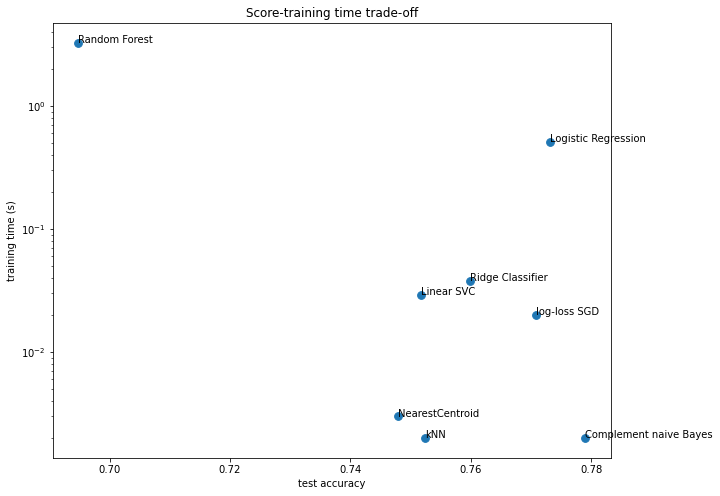

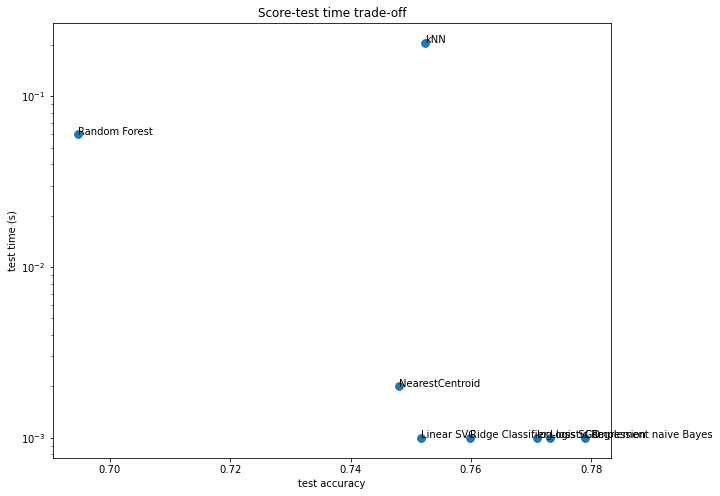

In [11]:
indices = np.arange(len(results))

results = [[x[i] for x in results] for i in range(4)]

clf_names, score, training_time, test_time = results
training_time = np.array(training_time)
test_time = np.array(test_time)

fig, ax1 = plt.subplots(figsize=(10, 8))
ax1.scatter(score, training_time, s=60)
ax1.set(
    title="Score-training time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="training time (s)",
)
fig, ax2 = plt.subplots(figsize=(10, 8))
ax2.scatter(score, test_time, s=60)
ax2.set(
    title="Score-test time trade-off",
    yscale="log",
    xlabel="test accuracy",
    ylabel="test time (s)",
)

for i, txt in enumerate(clf_names):
    ax1.annotate(txt, (score[i], training_time[i]))
    ax2.annotate(txt, (score[i], test_time[i]))

Le modèle naïf de Bayes offre le meilleur compromis entre le score et le temps d'entraînement/de test, tandis que Random Forest est à la fois lent à entraîner, coûteux à prédire et a une précision relativement mauvaise. Ceci est attendu : pour les problèmes de prédiction de grande dimension, les modèles linéaires sont souvent mieux adaptés car la plupart des problèmes deviennent linéairement séparables lorsque l'espace des caractéristiques a 10 000 dimensions ou plus.

La différence de vitesse d'apprentissage et de précision des modèles linéaires peut s'expliquer par le choix de la fonction de perte qu'ils optimisent et le type de régularisation qu'ils utilisent. Sachez que certains modèles linéaires avec la même perte mais une configuration de solveur ou de régularisation différente peuvent donner des temps d'ajustement et une précision de test différents. Nous pouvons observer sur le deuxième graphique qu'une fois entraînés, tous les modèles linéaires ont approximativement la même vitesse de prédiction qui est attendue car ils implémentent tous la même fonction de prédiction.

KNeighborsClassifier a une précision relativement faible et a le temps de test le plus élevé. Le long temps de prédiction est également attendu : pour chaque prédiction, le modèle doit calculer les distances par paires entre l'échantillon de test et chaque document de l'ensemble d'apprentissage, ce qui est coûteux en calculs. De plus, la « malédiction de la dimensionnalité » nuit à la capacité de ce modèle à produire une précision compétitive dans l'espace des caractéristiques à haute dimension des problèmes de classification de texte.